<a href="https://colab.research.google.com/github/AbrarAlotaibi/WiDS-KFUPM-Workshop-2025/blob/main/Paper_Analysis_%26_Literature_Review_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper Analysis & Literature Review Generator

By: Abrar Aloyaibi

This notebook allows you to:
1. Load filtered papers from a CSV file (from our previous filtering system)
2. Generate a comprehensive literature review
3. Create a comparison table of the papers
4. Export results to CSV and LaTeX (for Overleaf)


In [9]:
# Install required packages
# Uncomment and run if needed
#!pip install openai pandas matplotlib tqdm pylatex PyPDF2

import pandas as pd
import openai
import json
import time
import re
import numpy as np
from IPython.display import display, HTML, Markdown
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import PyPDF2
import io
import requests

warnings.filterwarnings('ignore')

# Set your OpenAI API key
OPENAI_API_KEY = "your-openai-api-key-here"
openai.api_key = OPENAI_API_KEY

# Verify API key is set (this doesn't check if it's valid, just that it's set)
if openai.api_key and openai.api_key != "your-openai-api-key-here":
    print("✅ API key configured.")
else:
    print("⚠️ Please replace the placeholder with your actual OpenAI API key.")

print("Libraries imported and API key configured.")

✅ API key configured.
Libraries imported and API key configured.


# Load papers from CSV

In [10]:
def load_papers_from_csv(csv_file_path):
    """
    Load papers from a CSV file and prepare them for analysis

    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing paper data

    Returns:
    --------
    DataFrame
        Pandas DataFrame containing the paper data
    """
    try:
        # Load the CSV file
        print(f"Loading papers from {csv_file_path}...")
        df = pd.read_csv(csv_file_path)

        # Check required columns
        required_columns = ['title', 'authors', 'summary', 'link', 'relevanceScore']
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            print(f"Warning: Missing required columns: {', '.join(missing_columns)}")
            return None

        # Convert string representations of lists back to actual lists
        if 'authors' in df.columns and isinstance(df['authors'].iloc[0], str):
            df['authors'] = df['authors'].apply(lambda x: eval(x) if isinstance(x, str) and '[' in x else x)

        if 'keyMatchingConcepts' in df.columns and isinstance(df['keyMatchingConcepts'].iloc[0], str):
            df['keyMatchingConcepts'] = df['keyMatchingConcepts'].apply(lambda x: eval(x) if isinstance(x, str) and '[' in x else x)

        # Display a summary of the loaded papers
        print(f"Successfully loaded {len(df)} papers.")
        print(f"Relevance score range: {df['relevanceScore'].min()} - {df['relevanceScore'].max()}")

        return df

    except Exception as e:
        print(f"Error loading papers: {e}")
        return None

# Example usage:
papers_df = load_papers_from_csv('arxiv_filtered_papers.csv')
if papers_df is not None:
     display(papers_df.head(3))

Loading papers from arxiv_filtered_papers.csv...
Successfully loaded 38 papers.
Relevance score range: 70 - 85


,Unnamed: 0,title,authors,summary,published,updated,link,categories,relevanceScore,relevanceExplanation,keyMatchingConcepts
0,0,Transfer Learning in Deep Reinforcement Learni...,"[Zhuangdi Zhu, Kaixiang Lin, Anil K. Jain, Jia...",Reinforcement learning is a learning paradigm ...,2020-09-16T18:38:54Z,2023-07-04T21:25:52Z,http://arxiv.org/abs/2009.07888v7,"['cs.LG', 'cs.AI', 'stat.ML']",85,This paper is highly relevant to the research ...,"[transfer learning, deep reinforcement learnin..."
1,1,Exploration by Distributional Reinforcement Le...,"[Yunhao Tang, Shipra Agrawal]",We propose a framework based on distributional...,2018-05-04T18:07:21Z,2018-06-21T16:57:32Z,http://arxiv.org/abs/1805.01907v2,"['cs.LG', 'cs.AI', 'stat.ML']",85,This paper is highly relevant to the research ...,"[distributional reinforcement learning, explor..."
2,2,Integration of Imitation Learning using GAIL a...,"[Akira Kinose, Tadahiro Taniguchi]",Integration of reinforcement learning and imit...,2019-07-03T21:38:48Z,2019-10-16T08:24:58Z,http://arxiv.org/abs/1907.02140v2,"['cs.LG', 'cs.AI', 'stat.ML']",85,This paper is highly relevant to the research ...,"[reinforcement learning, imitation learning, p..."


# Download and Extract Text from PDFs

In [11]:
def download_and_extract_paper_text(paper_link):
    """
    Download a paper PDF from arXiv and extract its text content

    Parameters:
    -----------
    paper_link : str
        arXiv link or ID for the paper

    Returns:
    --------
    str
        Extracted text content from the PDF
    """
    try:
        # Extract arXiv ID from the link
        arxiv_id = paper_link.split('/')[-1]
        if 'abs' in arxiv_id:
            arxiv_id = arxiv_id.replace('abs/', '')

        print(f"Downloading PDF for arXiv ID: {arxiv_id}")

        # Construct PDF URL
        pdf_url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"

        # Download the PDF
        response = requests.get(pdf_url)
        if response.status_code != 200:
            print(f"Failed to download PDF: {response.status_code}")
            return None

        # Parse the PDF content
        try:
            pdf_content = io.BytesIO(response.content)
            pdf_reader = PyPDF2.PdfReader(pdf_content)

            # Extract text from each page
            text = ""
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text() + "\n"

            print(f"Successfully extracted {len(text)} characters from PDF")

            # Basic cleaning
            text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space

            return text
        except Exception as e:
            print(f"Error extracting text from PDF: {e}")
            return None

    except ImportError:
        print("PyPDF2 module not installed. Installing now...")
        try:

            # Retry extraction after installation
            return download_and_extract_paper_text(paper_link)
        except Exception as e:
            print(f"Failed to install or use PyPDF2: {e}")
            return None
    except Exception as e:
        print(f"Error processing paper: {e}")
        return None

def enhance_papers_with_full_text(papers_df, max_papers=None):
    """
    Download and add full text content to papers

    Parameters:
    -----------
    papers_df : DataFrame
        DataFrame containing papers
    max_papers : int, optional
        Maximum number of papers to process

    Returns:
    --------
    DataFrame
        Papers DataFrame with added full_text column
    """
    if papers_df is None or len(papers_df) == 0:
        print("No papers available.")
        return papers_df

    # Sort by relevance and limit number of papers if specified
    if max_papers is not None and max_papers < len(papers_df):
        papers_to_process = papers_df.sort_values('relevanceScore', ascending=False).head(max_papers)
    else:
        papers_to_process = papers_df

    # Add a new column for full text
    papers_to_process['full_text'] = None

    print(f"Downloading and extracting text from {len(papers_to_process)} papers...")

    # Process each paper
    for idx, paper in tqdm(papers_to_process.iterrows(), total=len(papers_to_process)):
        # Download and extract text
        full_text = download_and_extract_paper_text(paper['link'])

        # Update the DataFrame
        if full_text:
            papers_df.at[idx, 'full_text'] = full_text
        else:
            # If extraction failed, use summary instead
            papers_df.at[idx, 'full_text'] = paper['summary']
            print(f"Using abstract as fallback for paper: {paper['title']}")

    # Count papers with full text
    full_text_count = papers_df['full_text'].notnull().sum()
    print(f"Successfully added full text to {full_text_count} papers.")

    return papers_df

# Example usage:
enhanced_df = enhance_papers_with_full_text(papers_df, max_papers=5)
print(f"First paper text length: {len(enhanced_df['full_text'].iloc[0])} characters")

  0%|          | 0/5 [00:00<?, ?it/s]

Successfully extracted 120045 characters from PDF
Successfully extracted 46750 characters from PDF
Successfully extracted 40756 characters from PDF
Successfully extracted 104930 characters from PDF
Successfully extracted 43988 characters from PDF
Successfully added full text to 5 papers.
First paper text length: 120037 characters


# Literature Review Generation

In [12]:
def generate_literature_review(papers_df, research_interest, min_relevance=70, max_papers=10):
    """
    Generate a comprehensive literature review from selected papers

    Parameters:
    -----------
    papers_df : DataFrame
        DataFrame containing the papers
    research_interest : str
        Research interest that the review should focus on
    min_relevance : int
        Minimum relevance score to include papers (0-100)
    max_papers : int
        Maximum number of papers to include in the review

    Returns:
    --------
    str
        Generated literature review text
    list
        List of papers included in the review
    """
    if papers_df is None or len(papers_df) == 0:
        print("No papers available for review generation.")
        return None, []

    # Filter papers by relevance score and take top N
    relevant_papers = papers_df[papers_df['relevanceScore'] >= min_relevance]
    relevant_papers = relevant_papers.sort_values('relevanceScore', ascending=False).head(max_papers)

    if len(relevant_papers) == 0:
        print(f"No papers with relevance score >= {min_relevance} found.")
        return None, []

    print(f"Generating literature review based on {len(relevant_papers)} papers...")

    # First, ensure we have full text for the papers if available
    if 'full_text' not in relevant_papers.columns:
        print("Full text not found. Downloading papers...")
        relevant_papers = enhance_papers_with_full_text(relevant_papers, max_papers=max_papers)

    # Prepare paper information for OpenAI
    papers_info = []
    for idx, paper in relevant_papers.iterrows():
        # Handle different author formats
        if isinstance(paper['authors'], list):
            authors_str = ', '.join(paper['authors'])
        elif isinstance(paper['authors'], str):
            # If it's already a string but not properly converted
            if paper['authors'].startswith('[') and paper['authors'].endswith(']'):
                authors_str = ', '.join(eval(paper['authors']))
            else:
                authors_str = paper['authors']
        else:
            authors_str = "Unknown Authors"

        # Get the paper text content (full text if available, summary as fallback)
        if 'full_text' in paper and paper['full_text'] is not None:
            content = paper['full_text']
            # Truncate if too long for API context window
            if len(content) > 15000:
                content = content[:15000] + "... [truncated]"
        else:
            content = paper['summary']

        # Create a structured representation of each paper
        paper_info = {
            'title': paper['title'],
            'authors': authors_str,
            'content': content,
            'relevance': paper['relevanceScore'],
            'link': paper['link']
        }
        papers_info.append(paper_info)

    # Create a prompt for OpenAI to generate the literature review
    papers_text = ""
    for i, paper in enumerate(papers_info, 1):
        papers_text += f"Paper {i}:\n"
        papers_text += f"Title: {paper['title']}\n"
        papers_text += f"Authors: {paper['authors']}\n"
        papers_text += f"Content: {paper['content'][:800]}... [content truncated for prompt]\n"
        papers_text += f"Relevance Score: {paper['relevance']}\n\n"

    prompt = f"""
I need you to create a comprehensive literature review based on the following papers,
focusing on the research interest: "{research_interest}".

{papers_text}

Please follow this structure for the literature review:
1. Introduction: Provide an overview of the research area and its importance.
2. Main Body: Analyze and synthesize the key findings, methodologies, and contributions of each paper,
   organizing by themes rather than discussing papers individually.
3. Gaps and Future Directions: Identify gaps in the literature and suggest future research directions.
4. Conclusion: Summarize the main insights from this literature review.

The literature review should be well-structured, scholarly, and about 1000-1500 words.

Format your response as:
<literature-review>
[The complete literature review text here]
</literature-review>
"""

    try:
        # Call OpenAI API to generate the literature review
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a research assistant specialized in creating comprehensive literature reviews from scientific papers. You excel at synthesizing information across multiple papers and identifying connections, themes, and gaps in the literature."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,  # Lower temperature for more scholarly output
            max_tokens=4000   # Allow enough tokens for a comprehensive review
        )

        # Extract the literature review from the response
        review_text = response.choices[0].message.content

        # Try to extract content between <literature-review> tags if present
        if "<literature-review>" in review_text and "</literature-review>" in review_text:
            review_text = re.search(r'<literature-review>(.*?)</literature-review>', review_text, re.DOTALL).group(1).strip()

        print("Literature review generated successfully!")
        return review_text, papers_info

    except Exception as e:
        print(f"Error generating literature review: {e}")
        return None, papers_info

# Example usage:
# research_interest = "Applications of reinforcement learning in robotic control systems with sparse rewards"
# review_text, included_papers = generate_literature_review(papers_df, research_interest, min_relevance=70, max_papers=8)
# if review_text:
#     display(Markdown("## Generated Literature Review"))
#     display(Markdown(review_text))

# Create Comparison Table

In [13]:
def create_comparison_table(papers_df, min_relevance=70, max_papers=10):
    """
    Create a structured comparison table of papers

    Parameters:
    -----------
    papers_df : DataFrame
        DataFrame containing the papers
    min_relevance : int
        Minimum relevance score to include papers (0-100)
    max_papers : int
        Maximum number of papers to include in the table

    Returns:
    --------
    DataFrame
        Comparison table as a DataFrame
    list
        List of papers included in the table
    """
    if papers_df is None or len(papers_df) == 0:
        print("No papers available for table creation.")
        return None, []

    # Filter papers by relevance score and take top N
    relevant_papers = papers_df[papers_df['relevanceScore'] >= min_relevance]
    relevant_papers = relevant_papers.sort_values('relevanceScore', ascending=False).head(max_papers)

    if len(relevant_papers) == 0:
        print(f"No papers with relevance score >= {min_relevance} found.")
        return None, []

    print(f"Creating comparison table for {len(relevant_papers)} papers...")

    # First, ensure we have full text for the papers if available
    if 'full_text' not in relevant_papers.columns:
        print("Full text not found. Downloading papers...")
        relevant_papers = enhance_papers_with_full_text(relevant_papers, max_papers=max_papers)

    # Prepare papers for analysis
    papers_info = []
    for idx, paper in relevant_papers.iterrows():
        # Handle different author formats
        if isinstance(paper['authors'], list):
            authors_str = ', '.join(paper['authors'])
        elif isinstance(paper['authors'], str):
            if paper['authors'].startswith('[') and paper['authors'].endswith(']'):
                authors_str = ', '.join(eval(paper['authors']))
            else:
                authors_str = paper['authors']
        else:
            authors_str = "Unknown Authors"

        # Get the paper text content (full text if available, summary as fallback)
        if 'full_text' in paper and paper['full_text'] is not None:
            content = paper['full_text']
            # Truncate if too long for API context window
            if len(content) > 15000:
                content = content[:15000] + "... [truncated]"
        else:
            content = paper['summary']

        # Create a structured representation of each paper
        paper_info = {
            'title': paper['title'],
            'authors': authors_str,
            'content': content,
            'relevance': paper['relevanceScore'],
            'link': paper['link']
        }
        papers_info.append(paper_info)

    # Use OpenAI to extract key aspects of each paper
    enhanced_papers = []

    print("Analyzing papers for comparison table...")
    for i, paper in enumerate(tqdm(papers_info)):
        try:
            # Create a prompt for OpenAI to extract key information
            prompt = f"""
Analyze the following scientific paper and extract key information in a structured format.

Title: {paper['title']}
Authors: {paper['authors']}
Content: {paper['content'][:3000]}... [content truncated for prompt]

Extract the following information in JSON format:
1. Main research question or objective
2. Methodology used (techniques, approaches, models)
3. Key findings or results
4. Limitations mentioned
5. Future work suggested
6. Year of publication (if available in the content, otherwise estimate based on context)

Format your response as a JSON object with the following keys:
{{
  "research_question": "The main research question or objective",
  "methodology": "The methodology, techniques, approaches used",
  "key_findings": "The main findings or results",
  "limitations": "Limitations of the study",
  "future_work": "Suggested future work",
  "year": "Publication year (or estimate)",
  "key_themes": ["theme1", "theme2", "theme3"]
}}
"""

            # Call OpenAI API to analyze the paper
            response = openai.chat.completions.create(
                model="gpt-4o-mini",  # Use a faster model for individual paper analysis
                messages=[
                    {"role": "system", "content": "You are a research assistant specialized in analyzing scientific papers and extracting key information. Be precise and concise."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.2,
                response_format={"type": "json_object"}
            )

            # Parse the JSON response
            analysis = json.loads(response.choices[0].message.content)

            # Add the analysis to the paper info
            enhanced_paper = paper.copy()
            enhanced_paper.update(analysis)
            enhanced_papers.append(enhanced_paper)

            # Add a small delay to avoid rate limits
            time.sleep(0.5)

        except Exception as e:
            print(f"Error analyzing paper {i+1}: {e}")
            # Add the original paper without enhanced analysis
            enhanced_papers.append(paper)

    # Create a comparison table as a DataFrame
    table_data = []
    for paper in enhanced_papers:
        # Extract key information for the table
        row = {
            'Title': paper['title'],
            'Authors': paper['authors'],
            'Relevance': paper['relevance'],
            'Research Question': paper.get('research_question', 'N/A'),
            'Methodology': paper.get('methodology', 'N/A'),
            'Key Findings': paper.get('key_findings', 'N/A'),
            'Limitations': paper.get('limitations', 'N/A'),
            'Future Work': paper.get('future_work', 'N/A'),
            'Year': paper.get('year', 'N/A'),
            'Link': paper['link']
        }
        table_data.append(row)

    # Create a DataFrame from the table data
    comparison_table = pd.DataFrame(table_data)

    print("Comparison table created successfully!")
    return comparison_table, enhanced_papers

# Example usage:
# comparison_df, enhanced_papers = create_comparison_table(papers_df, min_relevance=70, max_papers=8)
# if comparison_df is not None:
#     display(comparison_df)

# Export for CSV

In [14]:
def export_to_csv(data, filename, data_type="comparison"):
    """
    Export data to a CSV file

    Parameters:
    -----------
    data : DataFrame or str
        Data to export (DataFrame for comparison table, str for literature review)
    filename : str
        Name for the output file
    data_type : str
        Type of data being exported ('comparison' or 'literature')

    Returns:
    --------
    str
        Path to the exported file
    """
    try:
        if data_type == "comparison" and isinstance(data, pd.DataFrame):
            # Export comparison table
            output_path = f"{filename}.csv"
            data.to_csv(output_path, index=False)
            print(f"Comparison table exported to {output_path}")
            return output_path

        elif data_type == "literature" and isinstance(data, str):
            # Export literature review as CSV
            # Create a DataFrame with the review text
            df = pd.DataFrame({
                'section': ['Literature Review'],
                'content': [data]
            })
            output_path = f"{filename}.csv"
            df.to_csv(output_path, index=False)
            print(f"Literature review exported to {output_path}")
            return output_path

        else:
            print(f"Invalid data type or format for CSV export: {data_type}")
            return None

    except Exception as e:
        print(f"Error exporting to CSV: {e}")
        return None

# Example usage:
# if comparison_df is not None:
#     export_to_csv(comparison_df, "paper_comparison_table", "comparison")
# if review_text:
#     export_to_csv(review_text, "literature_review", "literature")

# Export to LaTeX (for Overleaf)

In [15]:
def export_to_latex(data, filename, data_type="comparison", research_interest=""):
    """
    Export data to LaTeX format for use in Overleaf

    Parameters:
    -----------
    data : DataFrame or str
        Data to export (DataFrame for comparison table, str for literature review)
    filename : str
        Name for the output file
    data_type : str
        Type of data being exported ('comparison' or 'literature')
    research_interest : str
        The research interest for the title (optional)

    Returns:
    --------
    str
        Path to the exported file
    """
    try:
        output_path = f"{filename}.txt"

        if data_type == "comparison" and isinstance(data, pd.DataFrame):
            # Create LaTeX for comparison table
            latex_content = "% LaTeX Comparison Table for Overleaf\n"
            latex_content += "% Generated on " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n\n"

            # Add document class and packages
            latex_content += "\\documentclass{article}\n"
            latex_content += "\\usepackage[utf8]{inputenc}\n"
            latex_content += "\\usepackage{booktabs}\n"
            latex_content += "\\usepackage{longtable}\n"
            latex_content += "\\usepackage{array}\n"
            latex_content += "\\usepackage{multirow}\n"
            latex_content += "\\usepackage{pdflscape}\n"
            latex_content += "\\usepackage{tabu}\n"
            latex_content += "\\usepackage{hyperref}\n\n"

            # Begin document
            latex_content += "\\begin{document}\n\n"

            # Add title
            if research_interest:
                latex_content += f"\\title{{Comparison of Papers on {research_interest}}}\n"
            else:
                latex_content += "\\title{Comparison of Scientific Papers}\n"
            latex_content += "\\author{Generated with AI Literature Review Tool}\n"
            latex_content += "\\date{\\today}\n"
            latex_content += "\\maketitle\n\n"

            # Begin landscape for wide table
            latex_content += "\\begin{landscape}\n"

            # Select columns to include in the table
            columns = ['Title', 'Authors', 'Year', 'Research Question', 'Methodology', 'Key Findings']

            # Create the table
            latex_content += "\\begin{longtabu} to \\linewidth {|p{3cm}|p{3cm}|p{1cm}|p{4cm}|p{4cm}|p{4cm}|}\n"
            latex_content += "\\caption{Comparison of Scientific Papers} \\\\\n"

            # Add table header
            latex_content += "\\hline\n"
            latex_content += " & ".join([f"\\textbf{{{col}}}" for col in columns]) + " \\\\\n"
            latex_content += "\\hline\n"
            latex_content += "\\endhead\n\n"

            # Add table rows
            for _, row in data[columns].iterrows():
                latex_row = []
                for col in columns:
                    # Clean the content for LaTeX
                    content = str(row[col]).replace('_', '\\_').replace('%', '\\%').replace('&', '\\&')
                    latex_row.append(content)

                latex_content += " & ".join(latex_row) + " \\\\\n"
                latex_content += "\\hline\n"

            # End table
            latex_content += "\\end{longtabu}\n"
            latex_content += "\\end{landscape}\n\n"

            # End document
            latex_content += "\\end{document}"

        elif data_type == "literature" and isinstance(data, str):
            # Create LaTeX for literature review
            latex_content = "% LaTeX Literature Review for Overleaf\n"
            latex_content += "% Generated on " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n\n"

            # Add document class and packages
            latex_content += "\\documentclass{article}\n"
            latex_content += "\\usepackage[utf8]{inputenc}\n"
            latex_content += "\\usepackage{natbib}\n"
            latex_content += "\\usepackage{hyperref}\n"
            latex_content += "\\usepackage{booktabs}\n\n"

            # Begin document
            latex_content += "\\begin{document}\n\n"

            # Add title
            if research_interest:
                latex_content += f"\\title{{Literature Review: {research_interest}}}\n"
            else:
                latex_content += "\\title{Literature Review}\n"
            latex_content += "\\author{Generated with AI Literature Review Tool}\n"
            latex_content += "\\date{\\today}\n"
            latex_content += "\\maketitle\n\n"

            # Add abstract
            latex_content += "\\begin{abstract}\n"
            latex_content += "This literature review synthesizes recent research papers on " + \
                             (research_interest if research_interest else "the selected topic") + \
                             ". The review was generated using an AI-assisted tool that analyzed multiple academic papers.\n"
            latex_content += "\\end{abstract}\n\n"

            # Process the literature review text for LaTeX
            # Convert markdown headers to LaTeX sections
            review_latex = data
            review_latex = re.sub(r'# (.*)', r'\\section{\1}', review_latex)
            review_latex = re.sub(r'## (.*)', r'\\subsection{\1}', review_latex)
            review_latex = re.sub(r'### (.*)', r'\\subsubsection{\1}', review_latex)

            # Convert markdown formatting
            review_latex = re.sub(r'\*\*(.*?)\*\*', r'\\textbf{\1}', review_latex)
            review_latex = re.sub(r'\*(.*?)\*', r'\\textit{\1}', review_latex)

            # Escape special characters
            review_latex = review_latex.replace('_', '\\_').replace('%', '\\%').replace('&', '\\&')

            # Add the processed review text
            latex_content += review_latex + "\n\n"

            # End document
            latex_content += "\\end{document}"

        else:
            print(f"Invalid data type or format for LaTeX export: {data_type}")
            return None

        # Write to file
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(latex_content)

        print(f"LaTeX content exported to {output_path}")
        return output_path

    except Exception as e:
        print(f"Error exporting to LaTeX: {e}")
        return None

# Example usage:
# if comparison_df is not None:
#     export_to_latex(comparison_df, "paper_comparison_latex", "comparison", research_interest)
# if review_text:
#     export_to_latex(review_text, "literature_review_latex", "literature", research_interest)

# Visualize Paper Relationships

In [16]:
def visualize_paper_relationships(enhanced_papers):
    """
    Create visualizations showing relationships between papers

    Parameters:
    -----------
    enhanced_papers : list
        List of papers with enhanced information
    """
    if not enhanced_papers:
        print("No papers available for visualization.")
        return

    print("Creating visualizations of paper relationships...")

    # Extract themes from papers
    themes = {}
    for paper in enhanced_papers:
        if 'key_themes' in paper and paper['key_themes']:
            for theme in paper['key_themes']:
                if theme in themes:
                    themes[theme] += 1
                else:
                    themes[theme] = 1

    # Create a dataframe with just titles and years for timeline
    paper_years = []
    for paper in enhanced_papers:
        year = paper.get('year', 'N/A')
        # Try to extract a year if it's not already in a standard format
        if year != 'N/A':
            # Try to extract a 4-digit year
            match = re.search(r'20\d\d', str(year))
            if match:
                year = int(match.group(0))

        paper_years.append({
            'title': paper['title'][:50] + '...' if len(paper['title']) > 50 else paper['title'],
            'year': year,
            'relevance': paper['relevance']
        })

    # Create a timeline of papers if we have year data
    has_years = any(isinstance(p['year'], (int, float)) for p in paper_years)
    if has_years:
        year_df = pd.DataFrame([p for p in paper_years if isinstance(p['year'], (int, float))])

        if len(year_df) > 0:
            plt.figure(figsize=(12, 6))
            plt.scatter(year_df['year'], year_df.index, s=year_df['relevance']*2, alpha=0.7)

            for i, row in year_df.iterrows():
                plt.text(row['year'], i, f"  {row['title']}", fontsize=9, va='center')

            plt.yticks([])
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.xlabel('Publication Year')
            plt.title('Timeline of Relevant Papers')
            plt.tight_layout()
            plt.show()

    # Create a bar chart of themes if we have theme data
    if themes:
        theme_df = pd.DataFrame(list(themes.items()), columns=['Theme', 'Count'])
        theme_df = theme_df.sort_values('Count', ascending=False).head(10)

        plt.figure(figsize=(12, 6))
        plt.barh(theme_df['Theme'], theme_df['Count'], color='skyblue')
        plt.xlabel('Number of Papers')
        plt.title('Common Themes Across Papers')
        plt.tight_layout()
        plt.show()

# Example usage:
# if enhanced_papers:
#     visualize_paper_relationships(enhanced_papers)

#  Interactive Interface

In [17]:
def interactive_analysis():
    """
    Create an interactive interface for paper analysis and literature review generation
    """
    from ipywidgets import widgets
    from IPython.display import display

    # Create widgets for file input
    file_input = widgets.Text(
        value='arxiv_filtered_papers.csv',
        description='CSV File:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )

    # Widget for research interest
    interest_input = widgets.Text(
        value='Applications of reinforcement learning in robotic control systems with sparse rewards',
        description='Research Interest:',
        style={'description_width': 'initial'},
        layout={'width': '70%'}
    )

    # Relevance threshold
    relevance_slider = widgets.IntSlider(
        value=70,
        min=0,
        max=100,
        step=5,
        description='Min Relevance:',
        style={'description_width': 'initial'}
    )

    # Max papers
    max_papers_slider = widgets.IntSlider(
        value=8,
        min=1,
        max=20,
        step=1,
        description='Max Papers:',
        style={'description_width': 'initial'}
    )

    # Download full text option
    download_papers = widgets.Checkbox(
        value=True,
        description='Download Full Paper Text',
        style={'description_width': 'initial'}
    )

    # Checkbox for outputs
    generate_review = widgets.Checkbox(
        value=True,
        description='Generate Literature Review',
        style={'description_width': 'initial'}
    )

    generate_table = widgets.Checkbox(
        value=True,
        description='Generate Comparison Table',
        style={'description_width': 'initial'}
    )

    export_csv = widgets.Checkbox(
        value=True,
        description='Export to CSV',
        style={'description_width': 'initial'}
    )

    export_latex = widgets.Checkbox(
        value=True,
        description='Export to LaTeX (Overleaf)',
        style={'description_width': 'initial'}
    )

    # Button to run analysis
    run_button = widgets.Button(
        description='Run Analysis',
        button_style='success',
        icon='play'
    )

    # Output widget for results
    output = widgets.Output()

    # Button click handler
    def on_run_button_click(b):
        with output:
            output.clear_output()

            # Load papers
            papers_df = load_papers_from_csv(file_input.value)
            if papers_df is None:
                return

            research_interest = interest_input.value
            min_relevance = relevance_slider.value
            max_papers = max_papers_slider.value

            # Download full paper text if selected
            if download_papers.value:
                papers_df = enhance_papers_with_full_text(papers_df, max_papers=max_papers)

            review_text = None
            comparison_df = None
            enhanced_papers = None

            # Generate literature review if selected
            if generate_review.value:
                review_text, included_papers = generate_literature_review(
                    papers_df, research_interest, min_relevance, max_papers
                )
                if review_text:
                    display(Markdown("## Generated Literature Review"))
                    display(Markdown(review_text))

            # Generate comparison table if selected
            if generate_table.value:
                comparison_df, enhanced_papers = create_comparison_table(
                    papers_df, min_relevance, max_papers
                )
                if comparison_df is not None:
                    display(Markdown("## Comparison Table"))
                    display(comparison_df)

            # Visualize relationships
            if enhanced_papers:
                visualize_paper_relationships(enhanced_papers)

            # Export to CSV if selected
            if export_csv.value:
                if comparison_df is not None:
                    export_to_csv(comparison_df, "paper_comparison_table", "comparison")
                if review_text:
                    export_to_csv(review_text, "literature_review", "literature")

            # Export to LaTeX if selected
            if export_latex.value:
                if comparison_df is not None:
                    export_to_latex(comparison_df, "paper_comparison_latex", "comparison", research_interest)
                if review_text:
                    export_to_latex(review_text, "literature_review_latex", "literature", research_interest)

    # Connect button to handler
    run_button.on_click(on_run_button_click)

    # Display widgets
    display(widgets.HTML("<h2>Paper Analysis and Literature Review Generator</h2>"))
    display(widgets.HBox([file_input]))
    display(widgets.HBox([interest_input]))
    display(widgets.HBox([relevance_slider, max_papers_slider]))
    display(widgets.HBox([download_papers]))
    display(widgets.HBox([generate_review, generate_table, export_csv, export_latex]))
    display(run_button)
    display(output)

# Uncomment to run the interactive interface
# interactive_analysis()

# Run the interactive analysis

In [18]:
# Uncomment to run the interactive interface
# interactive_analysis()

# Simple Example Usage

Loading papers from arxiv_filtered_papers.csv...
Successfully loaded 38 papers.
Relevance score range: 70 - 85


  0%|          | 0/8 [00:00<?, ?it/s]

Successfully extracted 120045 characters from PDF
Successfully extracted 46750 characters from PDF
Successfully extracted 40756 characters from PDF
Successfully extracted 104930 characters from PDF
Successfully extracted 43988 characters from PDF
Successfully extracted 46898 characters from PDF
Successfully extracted 66344 characters from PDF
Successfully extracted 81789 characters from PDF
Successfully added full text to 8 papers.
Generating literature review based on 8 papers...
Literature review generated successfully!


## Generated Literature Review

**1. Introduction**

Reinforcement learning (RL) has emerged as a transformative paradigm in artificial intelligence, particularly in the realm of robotic control systems. It enables agents to learn optimal behaviors through interactions with their environments, primarily by maximizing cumulative rewards. However, one of the significant challenges in RL is the sparsity of rewards, which can impede the learning process, especially in complex environments. The integration of various learning methodologies, such as transfer learning, imitation learning, and memory systems, has been proposed to enhance the efficiency of RL in robotic applications. This literature review synthesizes recent advancements in the application of reinforcement learning in robotic control systems, focusing on the challenges posed by sparse rewards and the innovative strategies employed to address these challenges.

**2. Main Body**

**2.1. Challenges of Sparse Rewards in Reinforcement Learning**

Sparse rewards present a significant hurdle in RL, as the agent may struggle to discern which actions lead to positive outcomes. This issue is particularly pronounced in robotic control systems, where the complexity of tasks often results in infrequent feedback. Several studies have highlighted the limitations of traditional RL approaches in environments with sparse rewards. For instance, the work by Arulkumaran et al. (Paper 4) emphasizes that while deep reinforcement learning (DRL) has shown promise in scaling to complex tasks, the learning process can be slow and inefficient when feedback is limited. This is echoed by Yang et al. (Paper 3), who discuss the slow propagation of reward information in deep RL, suggesting that alternative learning mechanisms may be necessary to enhance learning speed and efficiency.

**2.2. Integration of Learning Paradigms**

To mitigate the challenges of sparse rewards, researchers have explored the integration of RL with other learning paradigms. Kinose and Taniguchi (Paper 2) propose a hybrid approach that combines imitation learning (IL) with RL through Generative Adversarial Imitation Learning (GAIL). This integration allows agents to leverage expert demonstrations to guide their learning, effectively reducing the reliance on sparse rewards. The authors argue that while RL optimizes policies based on rewards, IL can provide valuable insights from expert trajectories, thereby accelerating the learning process.

Moreover, Lü et al. (Paper 5) introduce a recruitment-imitation mechanism that combines evolutionary algorithms with RL and IL. This approach aims to enhance sample efficiency and stability in continuous control tasks. By utilizing expert data to inform the learning process, the method addresses the challenges posed by sparse rewards, allowing for more robust policy learning in robotic systems.

**2.3. Memory Systems in Reinforcement Learning**

The incorporation of memory systems into RL frameworks has also gained traction as a means to improve learning efficiency. Yang et al. (Paper 3) present the concept of Two-Memory Reinforcement Learning, which utilizes both episodic memory and parametric neural networks. This dual-memory approach allows agents to store and retrieve experiences, facilitating faster learning and better decision-making in environments with sparse feedback. The authors highlight that episodic memory can provide quick access to past experiences, thereby enhancing the agent's ability to learn from limited rewards.

In a similar vein, Yu and Lee (Paper 6) propose an equivariant reinforcement learning framework for quadrotor UAVs, which reduces the dimensionality of the state space by leveraging the equivariance properties of the quadrotor dynamics. This reduction in complexity improves sampling efficiency, allowing the agent to learn more effectively even in environments characterized by sparse rewards.

**2.4. Abstraction and State Representation**

Another promising avenue of research involves the abstraction of states to facilitate learning in RL. Patil et al. (Paper 8) introduce contrastive abstraction learning, which aims to cluster states into abstract representations. By reducing the number of states the agent must consider, this approach addresses the challenges associated with long trajectories and sparse rewards. The authors argue that while deep RL can identify abstract states, the instability of end-to-end learning necessitates the development of more robust methods for state abstraction.

**2.5. Transfer Learning in Reinforcement Learning**

Transfer learning has emerged as a vital strategy for enhancing the efficiency of RL, particularly in scenarios where agents must adapt to new tasks or environments with limited data. Zhu et al. (Paper 1) provide a comprehensive survey of transfer learning techniques in deep RL, highlighting their potential to facilitate knowledge transfer from previously learned tasks to new ones. This capability is particularly beneficial in robotic control systems, where agents can leverage prior experiences to improve learning in sparse reward settings.

**3. Gaps and Future Directions**

Despite the advancements in integrating various learning paradigms and enhancing memory systems, several gaps remain in the literature. First, there is a need for more empirical studies that evaluate the effectiveness of these hybrid approaches in real-world robotic applications. While theoretical frameworks and simulations provide valuable insights, practical implementations are crucial for understanding the limitations and potential of these methods.

Additionally, the exploration of novel state representation techniques is an area ripe for further investigation. While contrastive abstraction shows promise, more research is needed to develop stable and efficient methods for state clustering that can be applied across diverse robotic tasks.

Finally, the interplay between exploration and exploitation in sparse reward environments remains an open question. Future research should focus on developing adaptive exploration strategies that can dynamically adjust based on the agent's learning progress and the availability of rewards.

**4. Conclusion**

The application of reinforcement learning in robotic control systems, particularly in the context of sparse rewards, presents both challenges and opportunities. The integration of imitation learning, memory systems, and transfer learning has shown promise in enhancing the efficiency and effectiveness of RL. However, significant gaps remain in empirical validation and the development of robust state representation techniques. As the field continues to evolve, addressing these challenges will be essential for unlocking the full potential of reinforcement learning in robotics and beyond.

Literature review exported to literature_review.csv
LaTeX content exported to literature_review_latex.txt
Creating comparison table for 8 papers...
Analyzing papers for comparison table...


  0%|          | 0/8 [00:00<?, ?it/s]

Comparison table created successfully!


## Comparison Table

,Title,Authors,Relevance,Research Question,Methodology,Key Findings,Limitations,Future Work,Year,Link
0,Transfer Learning in Deep Reinforcement Learni...,"Zhuangdi Zhu, Kaixiang Lin, Anil K. Jain, Jiay...",85,How can transfer learning approaches enhance t...,The survey categorizes state-of-the-art transf...,Transfer learning can significantly improve th...,The paper discusses potential challenges in tr...,Exploration of unresolved challenges in transf...,2023,http://arxiv.org/abs/2009.07888v7
1,Integration of Imitation Learning using GAIL a...,"Akira Kinose, Tadahiro Taniguchi",85,How can reinforcement learning (RL) and imitat...,The paper extends the probabilistic graphical ...,The integrated learning method of RL and IL ac...,Many existing methods for integrating RL and I...,The paper suggests further exploration of the ...,2019,http://arxiv.org/abs/1907.02140v2
2,Two-Memory Reinforcement Learning,"Zhao Yang, Thomas. M. Moerland, Mike Preuss, A...",85,How can episodic memory and reinforcement lear...,The study proposes a Two-Memory reinforcement ...,The 2M agent is more data efficient and outper...,The paper does not explicitly mention limitati...,The proposed approach offers a general framewo...,2023,http://arxiv.org/abs/2304.10098v2
3,A Brief Survey of Deep Reinforcement Learning,"Kai Arulkumaran, Marc Peter Deisenroth, Miles ...",85,How can deep reinforcement learning revolution...,The survey covers value-based and policy-based...,Deep reinforcement learning allows for the sca...,Previous reinforcement learning approaches lac...,The paper describes several current areas of r...,2023,http://arxiv.org/abs/1708.05866v2
4,Recruitment-imitation Mechanism for Evolutiona...,"Shuai Lü, Shuai Han, Wenbo Zhou, Junwei Zhang",85,How can the advantages of reinforcement learni...,The study proposes the Recruitment-imitation M...,RIM outperforms prior evolutionary and reinfor...,The paper does not explicitly mention limitati...,Future work is not explicitly detailed in the ...,2019,http://arxiv.org/abs/1912.06310v1
5,Equivariant Reinforcement Learning for Quadrot...,"Beomyeol Yu, Taeyoung Lee",85,How can equivariant properties of quadrotor dy...,An equivariant reinforcement learning framewor...,The identification of an equivariance property...,The study may be limited by the reliance on sp...,Further exploration of the equivariant propert...,2023,http://arxiv.org/abs/2206.01233v2
6,Hybrid computer approach to train a machine le...,"Mirko Holzer, Bernd Ulmann",85,"How can a hybrid computer setup, combining dig...",A hybrid computer approach involving a digital...,The hybrid approach provides a solution to the...,The content does not explicitly mention limita...,"The chapter does not specify future work, but ...",2021,http://arxiv.org/abs/2103.07802v1
7,Contrastive Abstraction for Reinforcement Lear...,"Vihang Patil, Markus Hofmarcher, Elisabeth Rum...",85,How can abstract representations of states be ...,"Contrastive abstraction learning, which includ...",Contrastive abstraction learning effectively c...,End-to-end learning of representations in deep...,Further exploration of state abstractions and ...,2023,http://arxiv.org/abs/2410.00704v1


Comparison table exported to paper_comparison_table.csv
LaTeX content exported to paper_comparison_latex.txt
Creating visualizations of paper relationships...


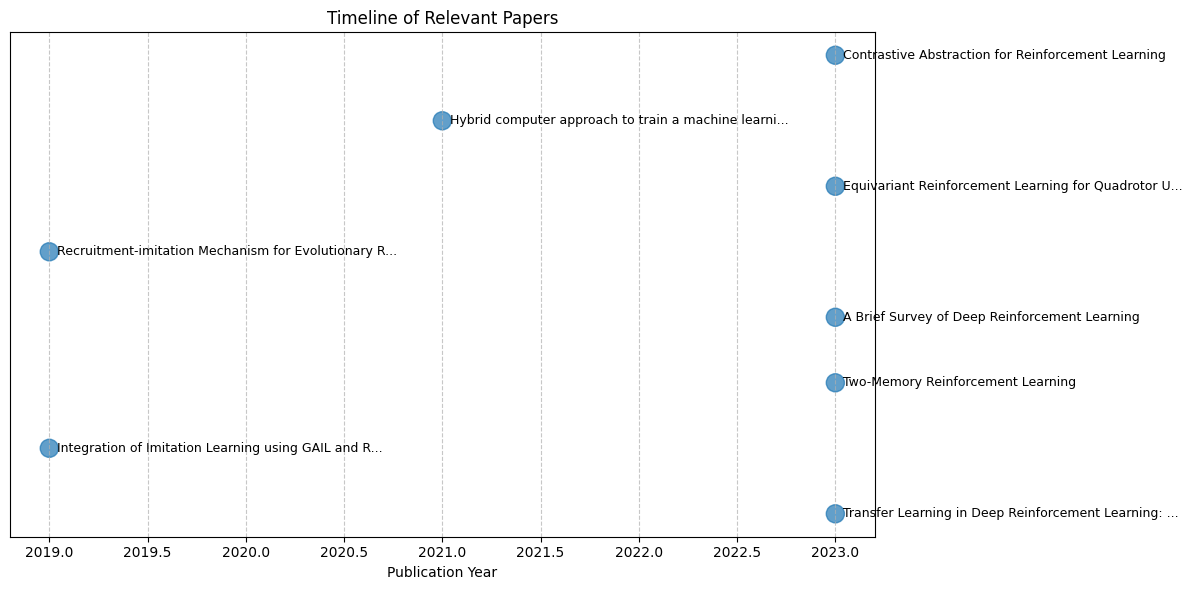

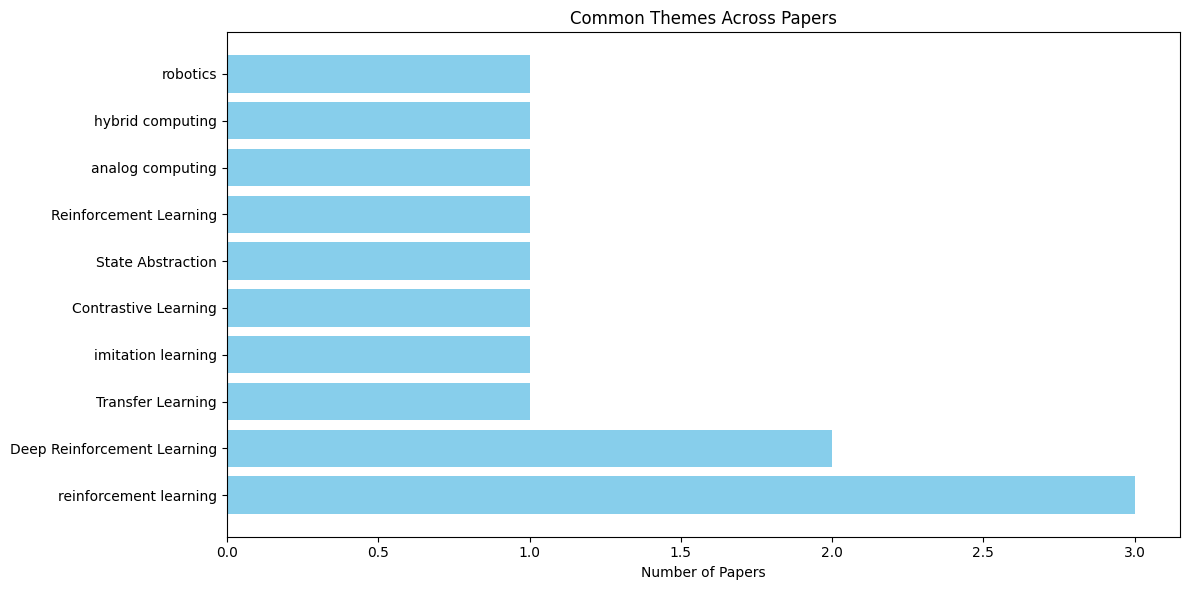

Example completed!


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Authors').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Research Question').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Methodology').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Relevance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Relevance'}, axis=1)
              .sort_values('Relevance', ascending=True))
  xs = counted['Relevance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Relevance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Title')):
  _plot_series(series, series_name, i)
  fig.legend(title='Title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Relevance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Relevance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Relevance'}, axis=1)
              .sort_values('Relevance', ascending=True))
  xs = counted['Relevance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Relevance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Authors')):
  _plot_series(series, series_name, i)
  fig.legend(title='Authors', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Relevance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Relevance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Relevance'}, axis=1)
              .sort_values('Relevance', ascending=True))
  xs = counted['Relevance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Relevance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Research Question')):
  _plot_series(series, series_name, i)
  fig.legend(title='Research Question', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Relevance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Relevance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Relevance'}, axis=1)
              .sort_values('Relevance', ascending=True))
  xs = counted['Relevance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Relevance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Methodology')):
  _plot_series(series, series_name, i)
  fig.legend(title='Methodology', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Relevance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Authors'].value_counts()
    for x_label, grp in _df_8.groupby('Title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Title')
_ = plt.ylabel('Authors')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Research Question'].value_counts()
    for x_label, grp in _df_9.groupby('Authors')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Authors')
_ = plt.ylabel('Research Question')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Methodology'].value_counts()
    for x_label, grp in _df_10.groupby('Research Question')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Research Question')
_ = plt.ylabel('Methodology')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Key Findings'].value_counts()
    for x_label, grp in _df_11.groupby('Methodology')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Methodology')
_ = plt.ylabel('Key Findings')

In [19]:
# Cell 10: Simple Example Usage
# ===========================

def run_simple_example():
    """
    Run a simple example of the entire pipeline
    """
    # Load papers from CSV
    papers_df = load_papers_from_csv('arxiv_filtered_papers.csv')
    if papers_df is None:
        print("Please make sure you have a file named 'arxiv_filtered_papers.csv' with the required columns.")
        return

    # Define parameters
    research_interest = "Applications of reinforcement learning in robotic control systems with sparse rewards"
    min_relevance = 70
    max_papers = 8

    # Download full paper text
    print("Downloading full paper text...")
    papers_df = enhance_papers_with_full_text(papers_df, max_papers=max_papers)

    # Generate literature review
    review_text, included_papers = generate_literature_review(
        papers_df, research_interest, min_relevance, max_papers
    )
    if review_text:
        display(Markdown("## Generated Literature Review"))
        display(Markdown(review_text))

        # Export literature review
        export_to_csv(review_text, "literature_review", "literature")
        export_to_latex(review_text, "literature_review_latex", "literature", research_interest)

    # Generate comparison table
    comparison_df, enhanced_papers = create_comparison_table(
        papers_df, min_relevance, max_papers
    )
    if comparison_df is not None:
        display(Markdown("## Comparison Table"))
        display(comparison_df)

        # Export comparison table
        export_to_csv(comparison_df, "paper_comparison_table", "comparison")
        export_to_latex(comparison_df, "paper_comparison_latex", "comparison", research_interest)

    # Visualize relationships between papers
    if enhanced_papers:
        visualize_paper_relationships(enhanced_papers)

    print("Example completed!")

# Uncomment to run the simple example
run_simple_example()